In [1]:
from sys import path
path.append('..')
from OTSax import *
import matplotlib.pyplot as plt
from jax import random
import optax
key = random.PRNGKey(0)

Error in sys.excepthook:
Traceback (most recent call last):
  File "f:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 1979, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'RuntimeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "f:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 1981, in showtraceback
    stb = self.InteractiveTB.structured_traceback(etype,
  File "f:\Anaconda3\lib\site-packages\IPython\core\ultratb.py", line 1105, in structured_traceback
    return FormattedTB.structured_traceback(
  File "f:\Anaconda3\lib\site-packages\IPython\core\ultratb.py", line 999, in structured_traceback
    return VerboseTB.structured_traceback(
  File "f:\Anaconda3\lib\site-packages\IPython\core\ultratb.py", line 851, in structured_traceback
    assert etb is not None
AssertionError

Original exception was:
RuntimeE

### Define parameterised distribution functions

In [2]:
@jax.jit
def IonMax(v,vi,Ti,Ai):
    sig2 = Ti/(Ai*amu_eV)
    norm = jnp.sqrt(2*jnp.pi*sig2)
    return jnp.exp(-0.5*(v-vi)**2/sig2)/norm

@jax.jit
def DerivativeIonMax(v,vi,Ti,Ai):
    sig2 = Ti/(Ai*amu_eV)
    norm = jnp.sqrt(2*jnp.pi*sig2)
    return -(v-vi)/sig2*jnp.exp(-0.5*(v-vi)**2/sig2)/norm

@jax.jit
def DoubleIonMax(v,vi_1,Ti_1,vi_2,Ti_2,Ai):
    sig2 = Ti_1/(Ai*amu_eV)
    norm = jnp.sqrt(2*jnp.pi*sig2)
    Max1 = jnp.exp(-0.5*(v-vi_1)**2/sig2)/norm
    sig2 = Ti_2/(Ai*amu_eV)
    norm = jnp.sqrt(2*jnp.pi*sig2)
    Max2 = jnp.exp(-0.5*(v-vi_2)**2/sig2)/norm
    return 0.5*(Max1+Max2)

### Set up laser and ion properties

In [3]:
# Laser parameters
laser_wavelength = 531.8e-9 # m
sa = 60.0 # Scattering angle in degrees

# Ion properties
Ai = 27.0
Zi = 13

Nomega = 2000
laser_params = create_laser_params(laser_wavelength,sa,Nomega)
wlsim_ang = laser_params['lambda_shift']*1e10

### Maxwellian example, comparing Maxwellian and non-Maxwellian code

In [4]:
ne = 1e18
Te = 20.0
ve = 50.0e3/sc.c

electron_params = create_Maxwellian_electron_params(ne,Te,ve)

vi = -50.0e3/sc.c
Ti = 20.0

Max_ion_params = create_Maxwellian_ion_params(electron_params,[Zi],[Ai],[vi],[Ti],[1.0])
nonMax_ion_params = create_nonMaxwellian_ion_params(electron_params,IonMax,3,[Zi],[Ai],[1.0],[[vi,Ti,Ai]])

from time import time
# Allow JITing
skw_max = calc_S_kw(laser_params,electron_params,Max_ion_params)
start = time()
skw_max = calc_S_kw(laser_params,electron_params,Max_ion_params)
max_time = time()-start

# Allow JITing
skw_nonmax = calc_S_kw(laser_params,electron_params,nonMax_ion_params)
start = time()
skw_nonmax = calc_S_kw(laser_params,electron_params,nonMax_ion_params)
nonmax_time = time()-start

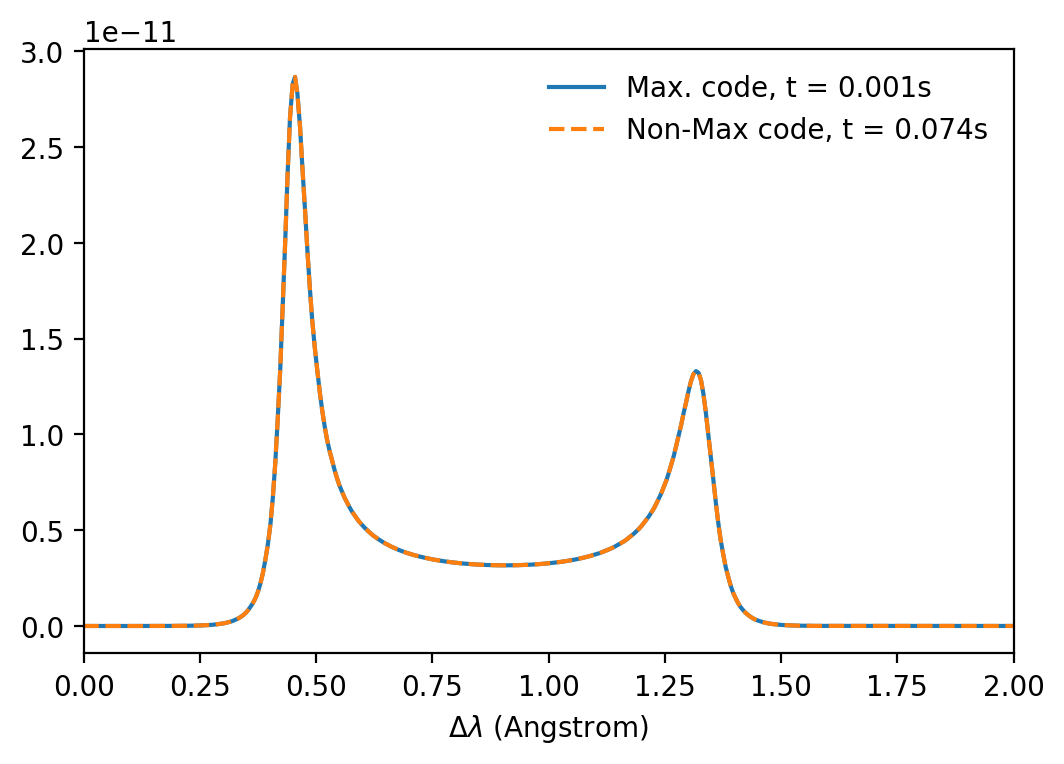

In [5]:
plt.figure(dpi=200)

plt.plot(wlsim_ang,skw_max,label=f'Max. code, t = {max_time:.3f}s')
plt.plot(wlsim_ang,skw_nonmax,ls='--',label=f'Non-Max code, t = {nonmax_time:.3f}s')

plt.legend(frameon=False)

plt.xlim(0.0,2.0)
plt.xlabel(r"$\Delta \lambda$ (Angstrom)")
# plt.ylim(0.0,1.4e-11)

plt.show()

### Two Maxwellian example

In [6]:
ne = 1e18
Te = 20.0
ve = 00.0e3/sc.c

electron_params = create_Maxwellian_electron_params(ne,Te,ve)

vi_1 = -50.0e3/sc.c
Ti_1 = 20.0

vi_2 = -5.0e3/sc.c
Ti_2 = 10.0

Max_ion_params = create_Maxwellian_ion_params(electron_params,[Zi,Zi],[Ai,Ai],[vi_1,vi_2],[Ti_1,Ti_2],[0.5,0.5])
nonMax_ion_params = create_nonMaxwellian_ion_params(electron_params,DoubleIonMax,5,[Zi],[Ai],[1.0],[[vi_1,Ti_1,vi_2,Ti_2,Ai]])

# Allow JITing
skw_nonmax = calc_S_kw(laser_params,electron_params,nonMax_ion_params)
start = time()
skw_nonmax = calc_S_kw(laser_params,electron_params,nonMax_ion_params)
nonmax_time = time()-start

skw_max = calc_S_kw(laser_params,electron_params,Max_ion_params)
start = time()
skw_max = calc_S_kw(laser_params,electron_params,Max_ion_params)
max_time = time()-start

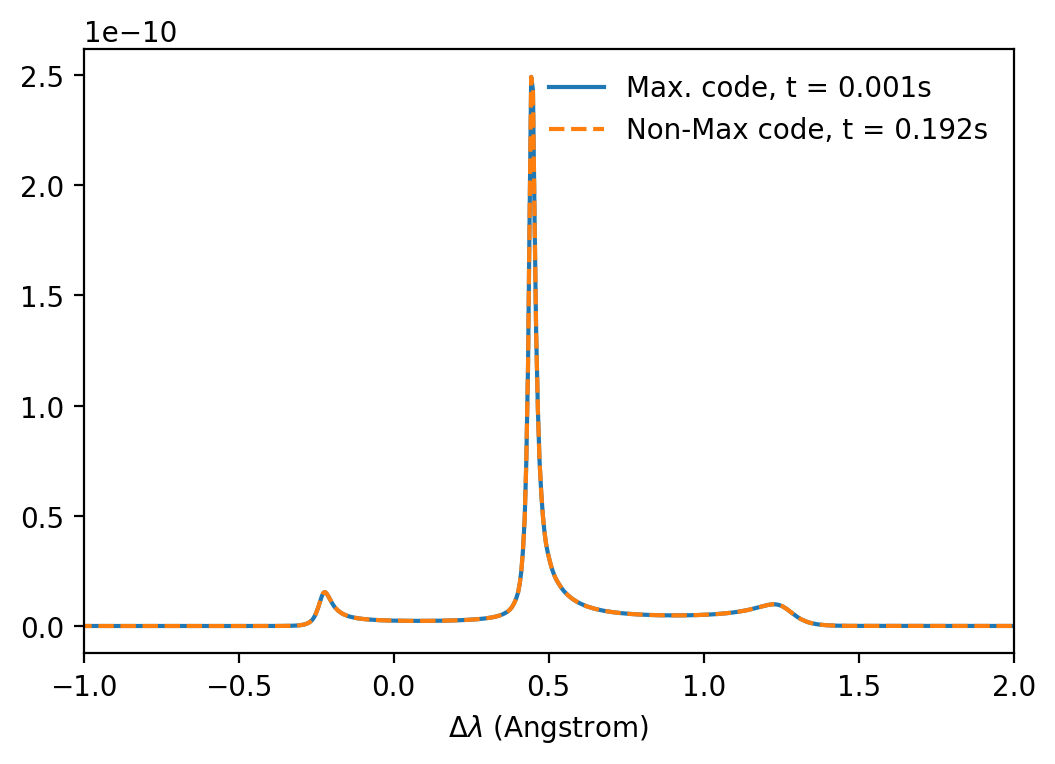

In [7]:
plt.figure(dpi=200)

plt.plot(wlsim_ang,skw_max,label=f'Max. code, t = {max_time:.3f}s')
plt.plot(wlsim_ang,skw_nonmax,ls='--',label=f'Non-Max code, t = {nonmax_time:.3f}s')

plt.legend(frameon=False)

plt.xlim(-1.0,2.0)
plt.xlabel(r"$\Delta \lambda$ (Angstrom)")

plt.show()

### Example fitting a non-Maxwellian

In [8]:
# Create synthetic data
synthetic_data = skw_nonmax + 1e-12*jax.random.normal(key,shape=skw_nonmax.shape)

Create and initialise optimizer

In [9]:
vi_1,Ti_1,vi_2,Ti_2 = -60.0e3/c, 15.0, 0.0e3/c, 20.0
nonMax_ion_params = update_nonMaxwellian_ion_params(nonMax_ion_params,electron_params,[1.0],[[vi_1,Ti_1,vi_2,Ti_2,Ai]])

initial_skw_nonmax = calc_S_kw(laser_params,electron_params,nonMax_ion_params)

In [10]:
def create_piecewise_learning_rate_schedule(init_value,total_steps,decay_rate,boundaries):
    boundaries_and_scales = {int(total_steps*b) : decay_rate for b in boundaries}
    learning_rate_schedule = optax.piecewise_constant_schedule(init_value,boundaries_and_scales=boundaries_and_scales)
    return learning_rate_schedule

def trainable_params_to_Skw_params(params,ion_params):
    vi_1,Ti_1,vi_2,Ti_2 = params['vi_1'],params['Ti_1'],params['vi_2'],params['Ti_2']
    # Scaling
    vi_1 /= v_scale
    Ti_1 /= T_scale
    vi_2 /= v_scale
    Ti_2 /= T_scale

    ion_params = update_nonMaxwellian_ion_params(ion_params,electron_params,[1.0],[[vi_1,Ti_1,vi_2,Ti_2,Ai]])
    return ion_params

def LossFunc(trainable_params,ion_params,scale_factor = 1e22):
    ion_params = trainable_params_to_Skw_params(trainable_params,ion_params)
    skw_nonmax = calc_S_kw(laser_params,electron_params,ion_params)
    loss = scale_factor*jnp.mean((skw_nonmax-synthetic_data)**2)
    return loss

LossGradFunc = jax.value_and_grad(LossFunc)

noptsteps = 200
learning_rate_schedule = create_piecewise_learning_rate_schedule(0.25,noptsteps,0.5,[1/4,1/2,3/4])

optimizer = optax.adam(learning_rate=learning_rate_schedule)

# Initial values of fit parameters
v_scale = c/1e3
T_scale = 1.0
params = {'vi_1': vi_1*v_scale,'Ti_1' : Ti_1*T_scale, 'vi_2' : vi_2*v_scale, 'Ti_2' : Ti_2*T_scale}
opt_state = optimizer.init(params)

In [11]:
start = time()
loss,grad_loss = LossGradFunc(params,nonMax_ion_params)
print('Loss grad eval takes:',time()-start,'s')
print(loss,grad_loss)

Loss grad eval takes: 14.044540643692017 s
1.3172771 {'Ti_1': Array(-0.00161265, dtype=float32), 'Ti_2': Array(-0.00946263, dtype=float32), 'vi_1': Array(-0.0046712, dtype=float32), 'vi_2': Array(0.02726461, dtype=float32)}


In [12]:
loss_history = []
for i in range(noptsteps):
    loss, grad_loss = LossGradFunc(params,nonMax_ion_params)

    updates, opt_state = optimizer.update(grad_loss, opt_state)
    params = optax.apply_updates(params, updates)

    loss_history.append(loss)

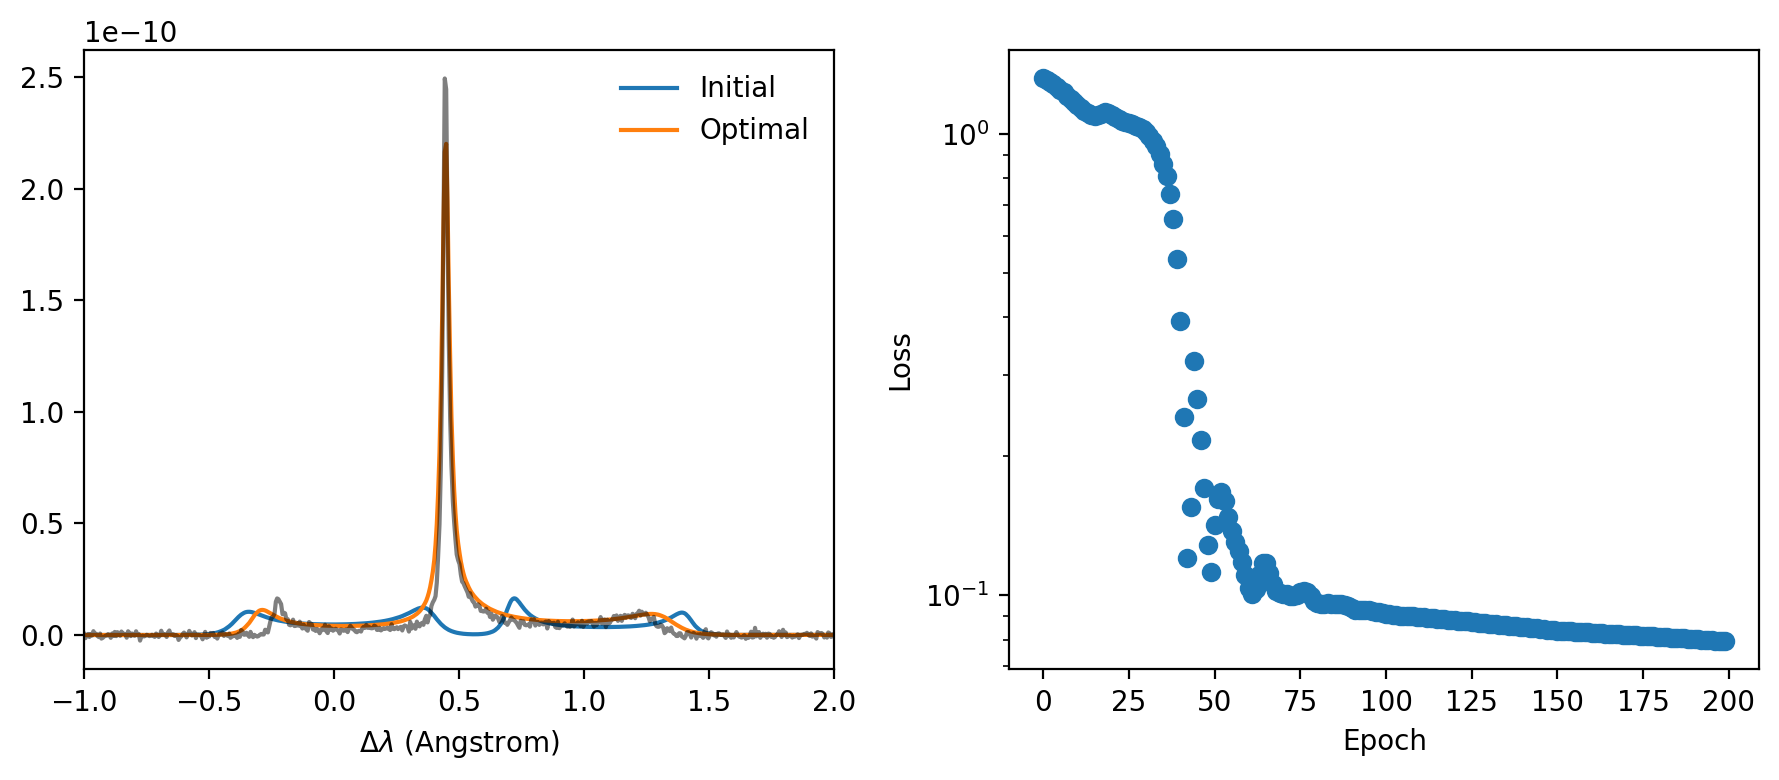

In [13]:
nonMax_ion_params = trainable_params_to_Skw_params(params,nonMax_ion_params)
optimal_skw_nonmax = calc_S_kw(laser_params,electron_params,nonMax_ion_params)

fig = plt.figure(dpi=200,figsize=(9,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(wlsim_ang,initial_skw_nonmax,label='Initial')
ax1.plot(wlsim_ang,optimal_skw_nonmax,label='Optimal')
ax1.plot(wlsim_ang,synthetic_data,'k',alpha=0.5)

ax1.set_xlim(-1.0,2.0)
ax1.set_xlabel(r"$\Delta \lambda$ (Angstrom)")

ax1.legend(frameon=False)

ax2.scatter(jnp.arange(noptsteps),loss_history)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.set_yscale('log')

fig.tight_layout()

plt.show()

In [14]:
params

{'Ti_1': Array(26.92171, dtype=float32),
 'Ti_2': Array(16.818588, dtype=float32),
 'vi_1': Array(-52.165745, dtype=float32),
 'vi_2': Array(-2.7733295, dtype=float32)}

### Example fitting multiple Maxwellians

In [15]:
def trainable_params_to_Skw_params(params,ion_params):
    vi_1,Ti_1,vi_2,Ti_2 = params['vi_1'],params['Ti_1'],params['vi_2'],params['Ti_2']
    # Scaling
    vi_1 /= v_scale
    Ti_1 /= T_scale
    vi_2 /= v_scale
    Ti_2 /= T_scale

    ion_params = update_Maxwellian_ion_params(ion_params,electron_params,[vi_1,vi_2],[Ti_1,Ti_2],[0.5,0.5])
    return ion_params

vi_1,Ti_1,vi_2,Ti_2 = -60.0e3/c, 15.0, 0.0e3/c, 20.0
Max_ion_params = update_Maxwellian_ion_params(Max_ion_params,electron_params,[vi_1,vi_2],[Ti_1,Ti_2],[0.5,0.5])

In [16]:
loss_history = []
for i in range(noptsteps):
    loss, grad_loss = LossGradFunc(params,Max_ion_params)

    updates, opt_state = optimizer.update(grad_loss, opt_state)
    params = optax.apply_updates(params, updates)

    loss_history.append(loss)

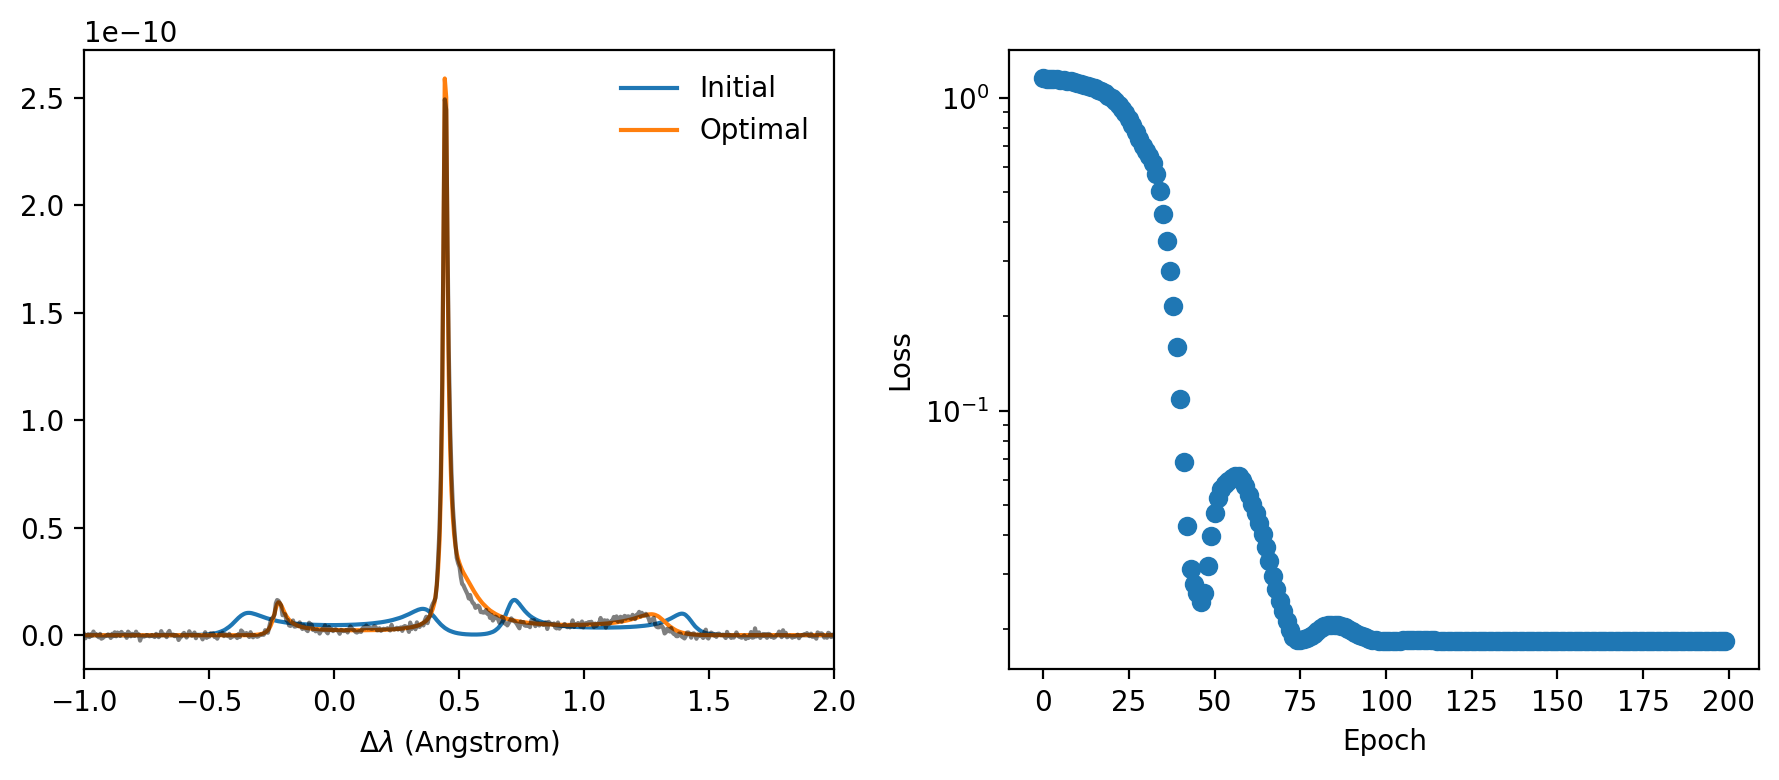

In [17]:
Max_ion_params = trainable_params_to_Skw_params(params,Max_ion_params)
optimal_skw_nonmax = calc_S_kw(laser_params,electron_params,Max_ion_params)

fig = plt.figure(dpi=200,figsize=(9,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(wlsim_ang,initial_skw_nonmax,label='Initial')
ax1.plot(wlsim_ang,optimal_skw_nonmax,label='Optimal')
ax1.plot(wlsim_ang,synthetic_data,'k',alpha=0.5)

ax1.set_xlim(-1.0,2.0)
ax1.set_xlabel(r"$\Delta \lambda$ (Angstrom)")

ax1.legend(frameon=False)

ax2.scatter(jnp.arange(noptsteps),loss_history)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.set_yscale('log')

fig.tight_layout()

plt.show()

In [18]:
params

{'Ti_1': Array(26.897852, dtype=float32),
 'Ti_2': Array(16.745985, dtype=float32),
 'vi_1': Array(-52.37811, dtype=float32),
 'vi_2': Array(-5.111616, dtype=float32)}